# Soft Landing of a Rocket
Ian Tsybulkin
<img src="falcon_lands.jpg" width="300">


In [291]:
from matplotlib import pyplot as plt 
import numpy as np

# Constats
m = 0.05e6          # 0.55e6 full mass

G = 9.81            # gravity
L = 35.5            # half length
D = 1.8             # radius of the rocket
F0 = 7.6e6          # full thrust

tau = 0.001         # integration step

# for more info:  https://en.wikipedia.org/wiki/Falcon_9

# Let us assume that we may change the angle of the rocket engines
#  at the range of ±6°

def lim(u, u_max=0.3):
    if u > u_max: return u_max
    if u < -u_max: return -u_max
    return u

Let us assume that just three out of 9 engines are used to control the rocket at a given plane (xz).
Thus, our thrust will be splited into two vectors having a little different angles **a** and **(a + u)**


$$ I \frac{d^2a}{dt^2} = -\frac{3}{9} L F_{th} sin(u) + D F_{th} \gamma, \space |\gamma| < 0.01, \space I = \frac{m L^2}{3}$$

$$ m \frac{d^2z}{dt^2} = \frac{6}{9} F_{th} cos(a) + \frac{3}{9} F_{th} cos(a+u) - mg  $$

$$ m \frac{d^2x}{dt^2} = -\frac{6}{9} F_{th} sin(a) - \frac{3}{9} F_{th} sin(a+u)  $$

![black box](black_box.jpeg)

# How to find a rocket thrust ? 

$$ F_{th} = \space ?$$


Let us assume that the rocket takes off with the full thrust. What will be its velocity and height in 10 seconds?

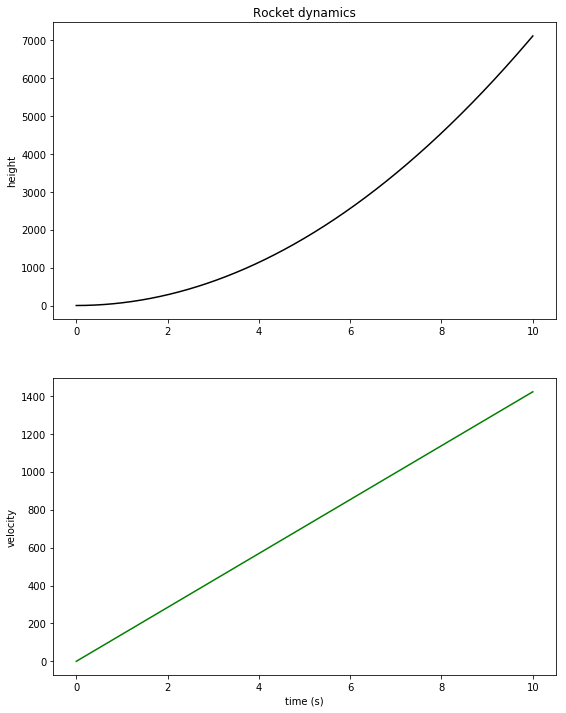

In [279]:
z, dz = 0, 0
t = 0

Z = [z]
DZ = [dz]
T = [t]
while t < 10:
    t += tau
    d2z = F0 / m - G
    dz += d2z * tau
    z += dz * tau
    
    DZ.append(dz)
    Z.append(z)
    T.append(t)
    
fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 12))

ax1.plot(T, Z, 'k-')
ax1.set(title='Rocket dynamics', ylabel='height')

ax2.plot(T, DZ, 'g-')
ax2.set(xlabel='time (s)', ylabel='velocity')

plt.show()

$$ z = \frac{1}{2} \big(\frac{F_{th}}{m} - g \big) (t - t_0)^2  $$

$$ \frac{dz}{dt} = \big( \frac{F_{th}}{m} - g \big) (t - t_0)  $$

In [202]:
v0 = 50
alpha = 0.1
t = v0 / (alpha*F0/m-G)
print "The time needed to decelerate the rocket from v0 = %i m/s:\nt = %.1f sec" %(v0, t)

The time needed to decelerate the rocket from v0 = 50 m/s:
t = 9.3 sec


The rocket accelerating at 45% of its full thrust will reach 340m within 3.4 seconds:

In [203]:
H = (F0*alpha/m - G)/2*t**2
print "Height = %i m" % H

Height = 231 m


$$ F_{th} = \bigg( \frac{\frac{dz}{dt}^2}{2z} + g \bigg ) m   $$

In [204]:
Fth = (v0**2/2/H+G)*m
print "Fth = %g kN  or %i%% of the full thrust" % (Fth / 1000., 100*Fth/F0)

Fth = 760 kN  or 10% of the full thrust


# Fuel consumption
The faster the rocket lands the less fuel it consumes.

In [171]:
k = m / 400        # fuel consumption at full thrust
print "%i kg/sec at full thrust" % k


125 kg/sec at full thrust


In [205]:
fuel = Fth / F0 * t * k
print "Fuel consumed during landing %i kg" % fuel

Fuel consumed during landing 115 kg


# Finding control

In [300]:
def no_control(x,dx,z,dz,a,da,u):
    return 0

In [289]:
def init():
    # t, x,dx, z,dz, a,da
    return 0., 1.5,0.5, H,-v0, 0.,0.

Landing successful
horizontal velocity: 0.025 m/s
vertical velocity:   -0.008 m/s
angular velocity:    0.00 1/s


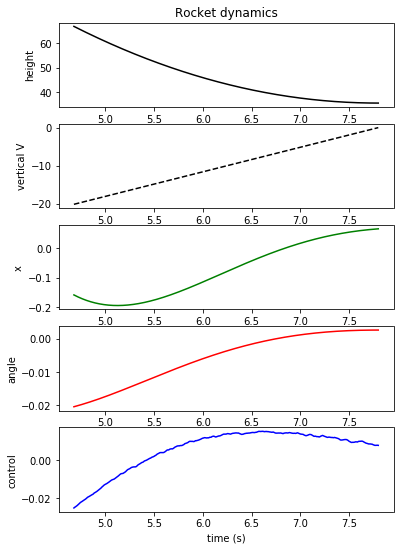

In [304]:
t, x,dx, z,dz, a,da = init()
u = 0

Z = [z]
dZ = [dz]
X = [x]
A = [a]
U = [u]
T = [t]
while t < 10:
    t += tau
    if z < L + 1e-3:
        break
    
    Fth = (dz**2/(z - L-0.99e-3)/2 + G) * m
    Fth = min(F0, max(0, Fth))
    
    u = lqr_control(x,dx,z,dz,a,da,u)
    # u = no_control(x,dx,z,dz,a,da,u)
    
    d2x = - Fth * (6./9. * np.sin(a) + 3./9. * np.sin(a + u)) / m
    dx += d2x * tau
    x += dx * tau
    
    d2z = Fth * (6./9. * np.cos(a) + 3./9. * np.cos(a + u)) / m - G
    dz += d2z * tau
    z += dz * tau
    
    gama = np.random.uniform(-0.01, 0.01)
    d2a = - Fth * ( 3. * L / 3 * np.sin(u)  + 3 * D * gama ) / m / L**2
    da += d2a * tau
    a += da * tau
    
    X.append(x)
    Z.append(z)
    dZ.append(dz)
    A.append(a)
    U.append(u)
    T.append(t)
    
if abs(x) < 10 and abs(dx) < 0.05 and abs(dz) < 0.2 and abs(a) < 0.1 and abs(da) < 0.05:
    print "Landing successful"
else:
    print "Landing failed"
print "horizontal velocity: %.3f m/s" % dx
print "vertical velocity:   %.3f m/s" % dz
print "angular velocity:    %.2f 1/s" % da


ht = int(len(T) * 0.6)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(6, 9))

ax1.plot(T[ht:], Z[ht:], 'k-')
ax1.set(title='Rocket dynamics', ylabel='height')

ax2.plot(T[ht:], dZ[ht:], 'k--')
ax2.set(ylabel='vertical V')

ax3.plot(T[ht:], X[ht:], 'g-')
ax3.set(ylabel='x')

ax4.plot(T[ht:], A[ht:], 'r-')
ax4.set(ylabel='angle')

ax5.plot(T[ht:], U[ht:], 'b-')
ax5.set(xlabel='time (s)', ylabel='control')


plt.show()

## Side view

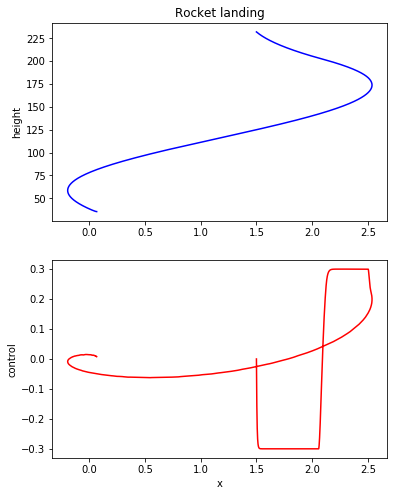

In [306]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8))

ax1.plot(X, Z, 'b-')
ax1.set(title='Rocket landing', ylabel='height')

ax2.plot(X, U, 'r-')
ax2.set(xlabel='x', ylabel='control')

plt.show()

<img src="barga1.png" width="300">

# LQR
Linear-quadrtic regulator

https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator

$$ \frac{d^2z}{dt^2} = \frac{F_{th}}{m} - g  $$

$$ \frac{d^2x}{dt^2} = -\frac{F_{th}}{m} a - \frac{3}{9m} F_{th} u  $$

$$ \frac{d^2a}{dt^2} = -\frac{2 F_{th}}{3mL} u  $$

Let us decrease the order of the equations by introducing two new variables: 

$$ v = \frac{dx}{dt}, \space w = \frac{da}{dt} $$



So, we get four linear equation of the first order

$$ \frac{dv}{dt} = -\frac{F_{th}}{m} a - \frac{3}{9m} F_{th} u  $$
$$ \frac{dx}{dt} = v  $$
$$ \frac{dw}{dt} = -\frac{2 F_{th}}{3mL} u  $$
$$ \frac{da}{dt} = w $$


or

$$ \frac{\vec dp}{dt} = A \vec p + B \vec u $$

In [270]:
Fth = (v0**2/(H - L)/2 + G) * m
A = np.array([[0, 0, 0, -Fth/m],
              [1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 1, 0]])
A

array([[  0.        ,   0.        ,   0.        , -16.17420741],
       [  1.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [271]:
B = np.array([[-3.*Fth/9/m, 0, -2*Fth/3/m/L, 0]]).T
B

array([[-5.39140247],
       [ 0.        ],
       [-0.30374098],
       [ 0.        ]])

Let us introduce a cost function, where Q and R are positive definite matrices:

$$ J = \int_{t_0}^{t_1} (p^T Q p + u^T R u) \space dt  \space \rightarrow min $$

$$ U = - K p  $$


In [295]:
Q = np.eye(4) * np.array([0.5, 10., 1., 1.])
R = np.eye(1)
print Q

[[  0.5   0.    0.    0. ]
 [  0.   10.    0.    0. ]
 [  0.    0.    1.    0. ]
 [  0.    0.    0.    1. ]]


<img src="barga.jpg" width="500">

In [272]:
import scipy.linalg



def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.    
    dx/dt = A x + B u     
    cost = integral x.T*Q*x + u.T*R*u
    """
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
     
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))
     
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
     
    return K, eigVals

In [273]:
K, eigenvals = lqr(A,B,Q,R)
print "K:",K,"\neigen vals:",eigenvals


K: [[   7.90433666    3.16227766 -169.15681547 -158.50185159]] 
eigen vals: [-3.43004471+2.31477802j -3.43004471-2.31477802j -0.95215402+0.025927j
 -0.95215402-0.025927j  ]


In [274]:
def lqr_control(x,dx,z,dz,a,da,u):
    K = np.array([ 7.90, 3.16, -169.15, -158.50])
    p = np.array([dx,x,da,a])
    u = 0.9*u + 0.1*lim(-np.dot(K,p)) # this is for add latency
    return u

## PID controller

https://en.wikipedia.org/wiki/PID_controller

<img src="pid.png" width="500">

In [245]:
R

array([[ 1.]])